In [3]:
install.packages('e1071')
library(ggplot2)
library(dplyr)
library(GGally)

library(Amelia)

library(scales) # Visualization
library(caTools) # Prediction: Splitting Data
library(car) # Prediction: Checking Multicollinearity
library(ROCR) # Prediction: ROC Curve
library(e1071) # Prediction: SVM, Naive Bayes, Parameter Tuning
library(rpart) # Prediction: Decision Tree
library(rpart.plot) # Prediction: Decision Tree
library(randomForest) # Prediction: Random Forest
library(caret) # Prediction: k-Fold Cross Validatio

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:dplyr’:

    combine

The following object is masked from ‘package:ggplot2’:

    margin

Loading required package: lattice


## Data cleaning and exploration

In [4]:
# loading the data
train = read.csv('train.csv', stringsAsFactors =)
test = read.csv('test.csv', stringsAsFactors = FALSE)
# Creating a new data set with both the test and the train sets
full = bind_rows(train,test)
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...


PassengerId    Survived      Pclass        Name         Sex         Age 
          0         418           0           0           0         263 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0           1           0           0

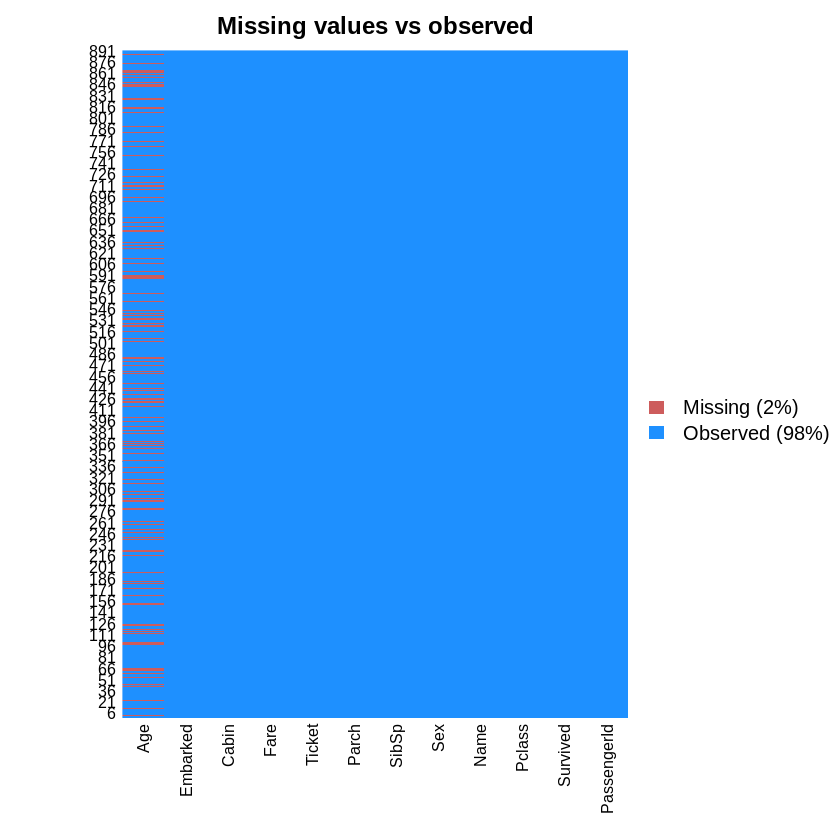

In [140]:
# Missing values
colSums(is.na(full))
missmap(train, main = "Missing values vs observed")

In [141]:
colSums(full=="")

PassengerId    Survived      Pclass        Name         Sex         Age 
          0          NA           0           0           0          NA 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          0           0           0          NA        1014           2

In [142]:
# We have a lot of missing data in the Age feature (263/1309)
# Let's change the empty strings in Embarked to the first choice "C"
full$Embarked[full$Embarked==""]="C"

In [143]:
# Let's see how many features we can move to factors
apply(full,2, function(x) length(unique(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
       1309           3           3        1307           2          99 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          7           8         929         282         187           3

In [144]:
# Let's move the features Survived, Pclass, Sex, Embarked to be factors
cols=c("Survived","Pclass","Sex","Embarked")
for (i in cols){
  full[,i] = as.factor(full[,i])
  train[,i] = as.factor(train[,i])
}

# Now lets look on the structure of the full data set
str(full)

'data.frame':	1309 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 1 2 2 ...
 $ Pclass     : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : Factor w/ 2 levels "female","male": 2 1 1 1 2 2 2 2 1 1 ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 2 3 3 3 1 ...


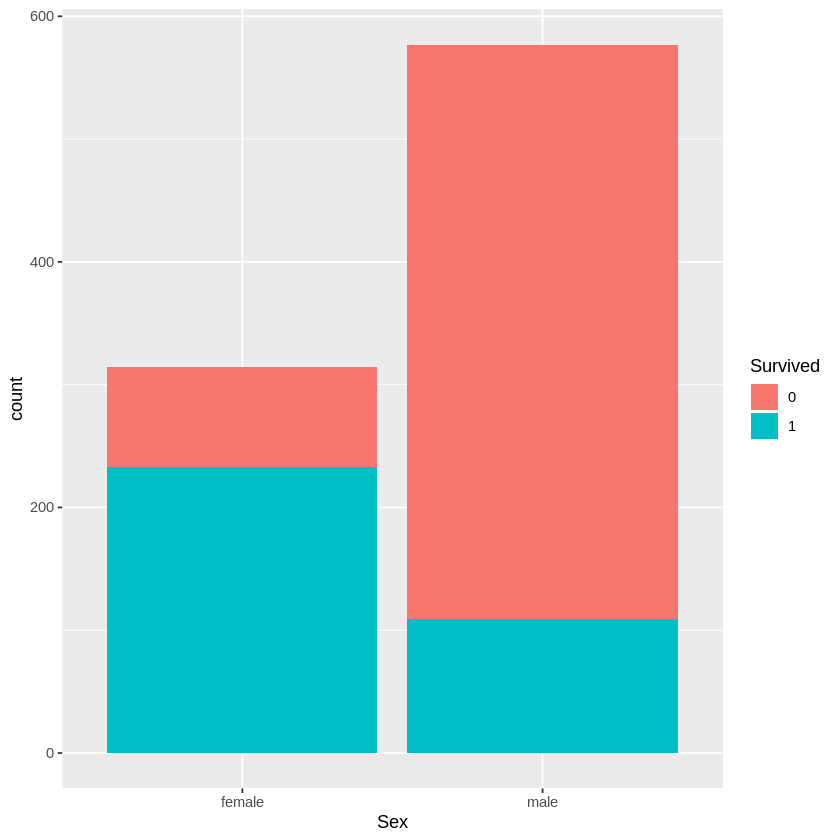

In [145]:
LT=dim(train)[1]
# First, let's look at the relationship between sex and survival:
#ggplot(data=full[1:LT,],aes(x=Sex,fill=Survived))+geom_bar()
ggplot(data=train,aes(x=Sex,fill=Survived))+geom_bar()

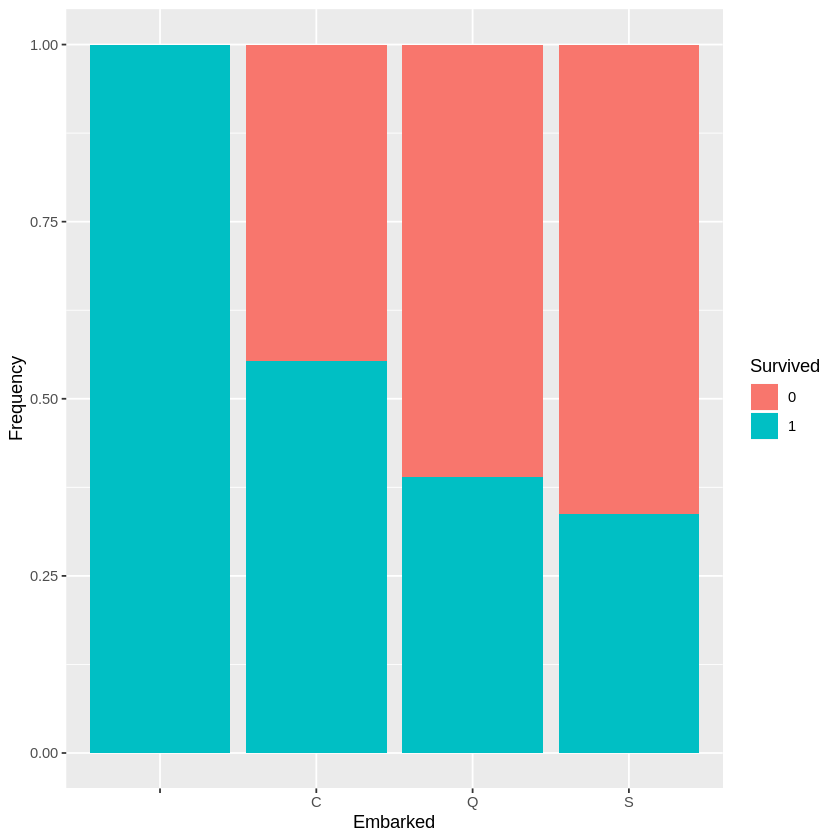

In [146]:
# Survival as a function of Embarked:
ggplot(data = train,aes(x=Embarked,fill=Survived))+geom_bar(position="fill")+ylab("Frequency")

In [147]:
t=table(train$Embarked,train$Survived)
t
for (i in 1:dim(t)[1]){
    t[i,]<-t[i,]/sum(t[i,])*100
}
t

   
      0   1
      0   2
  C  75  93
  Q  47  30
  S 427 217

   
            0         1
      0.00000 100.00000
  C  44.64286  55.35714
  Q  61.03896  38.96104
  S  66.30435  33.69565

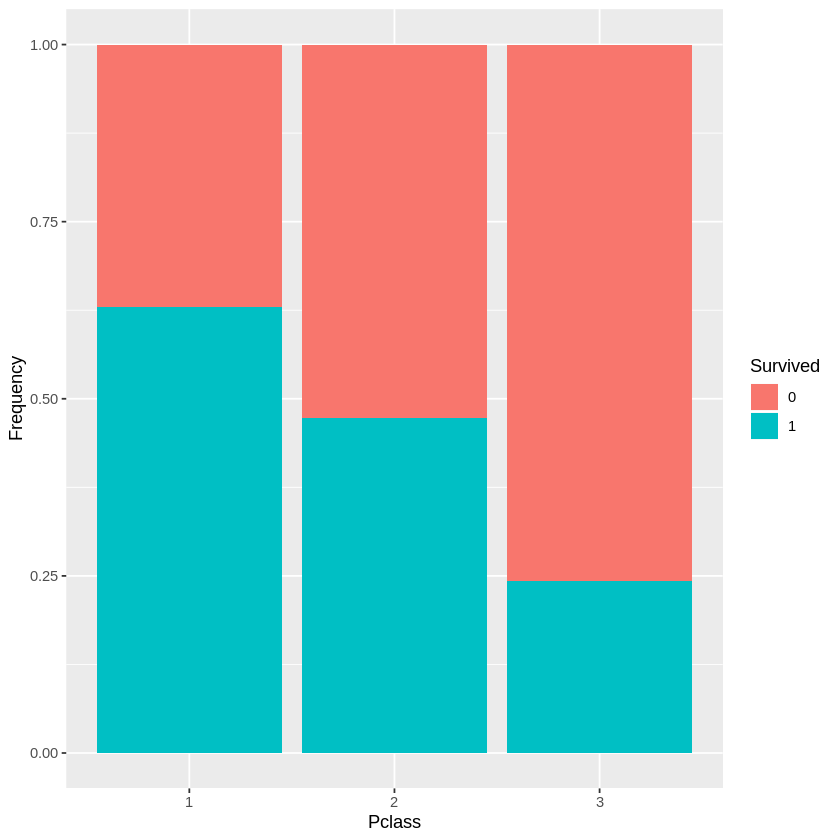

In [148]:
#It looks that you have a better chance to survive if you Embarked in 'C' (55% compared to 33% and 38%).

# Survival as a function of Pclass:
ggplot(data = full[1:LT,],aes(x=Pclass,fill=Survived))+geom_bar(position="fill")+ylab("Frequency")

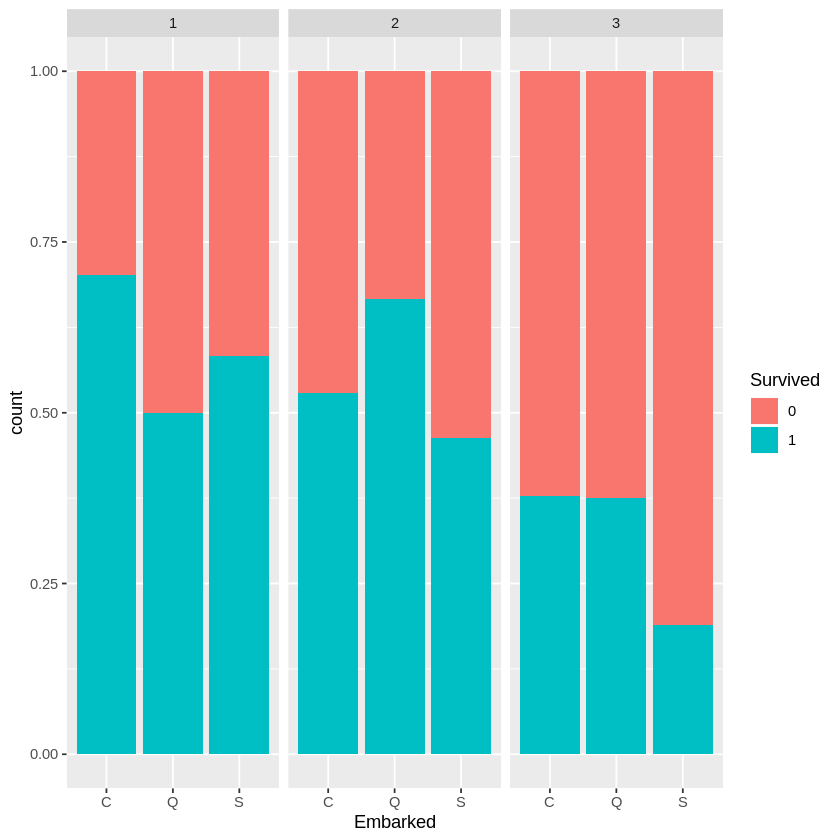

In [149]:
# Now, let's devide the graph of Embarked by Pclass:
ggplot(data = full[1:LT,],aes(x=Embarked,fill=Survived))+geom_bar(position="fill")+facet_wrap(~Pclass)

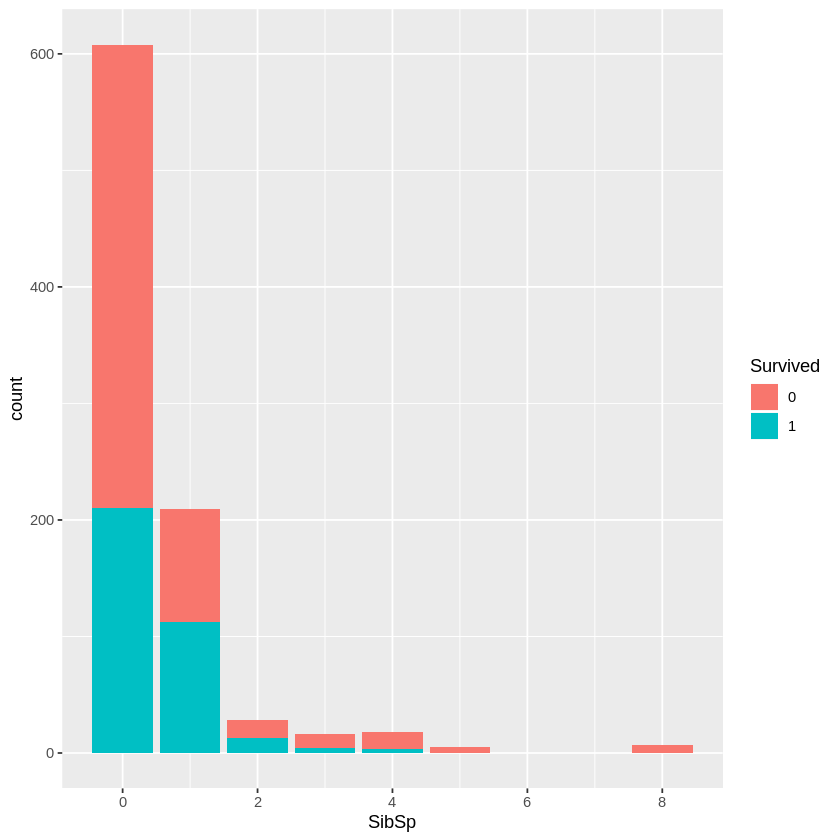

In [150]:
# It looks like you have a better chance to survive if you in lower 
#ticket class.

## Now it's not so clear that there is a correlation between Embarked and Survival. 

# Survivial as a function of SibSp and Parch
ggplot(data = full[1:LT,],aes(x=SibSp,fill=Survived))+geom_bar()

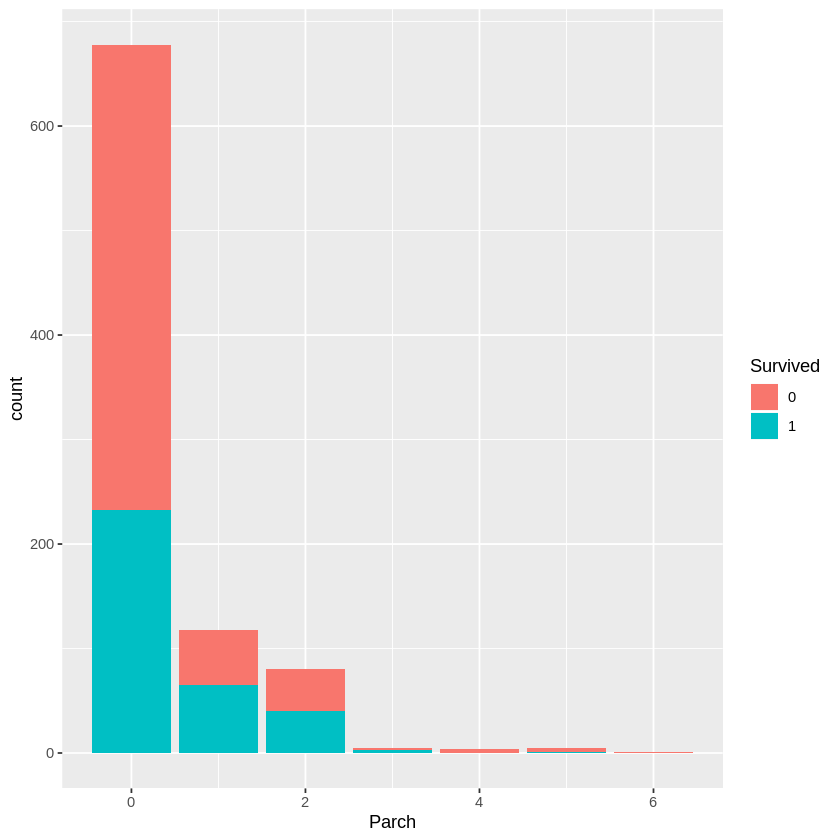

In [151]:
ggplot(data = full[1:LT,],aes(x=Parch,fill=Survived))+geom_bar()

Warning message:
“Removed 4 rows containing missing values (geom_bar).”

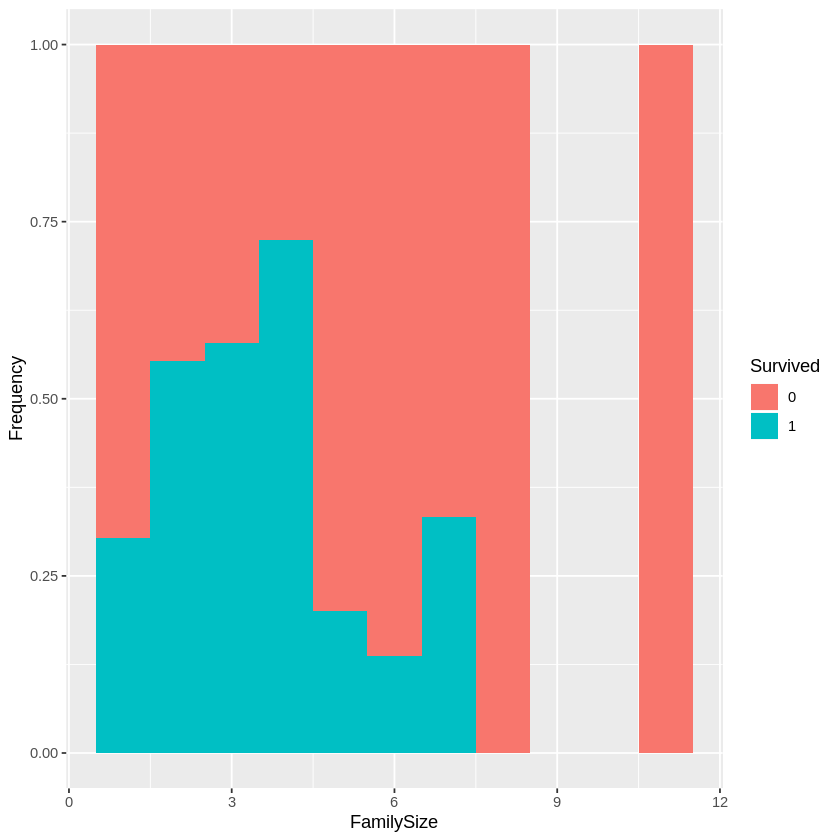

In [152]:
# The dymanics of SibSp and Parch are very close one each other.
# Let's try to look at another parameter: family size.

full$FamilySize <- full$SibSp + full$Parch +1;
full1<-full[1:LT,]
ggplot(data = full1[!is.na(full[1:LT,]$FamilySize),],aes(x=FamilySize,fill=Survived))+geom_histogram(binwidth =1,position="fill")+ylab("Frequency")

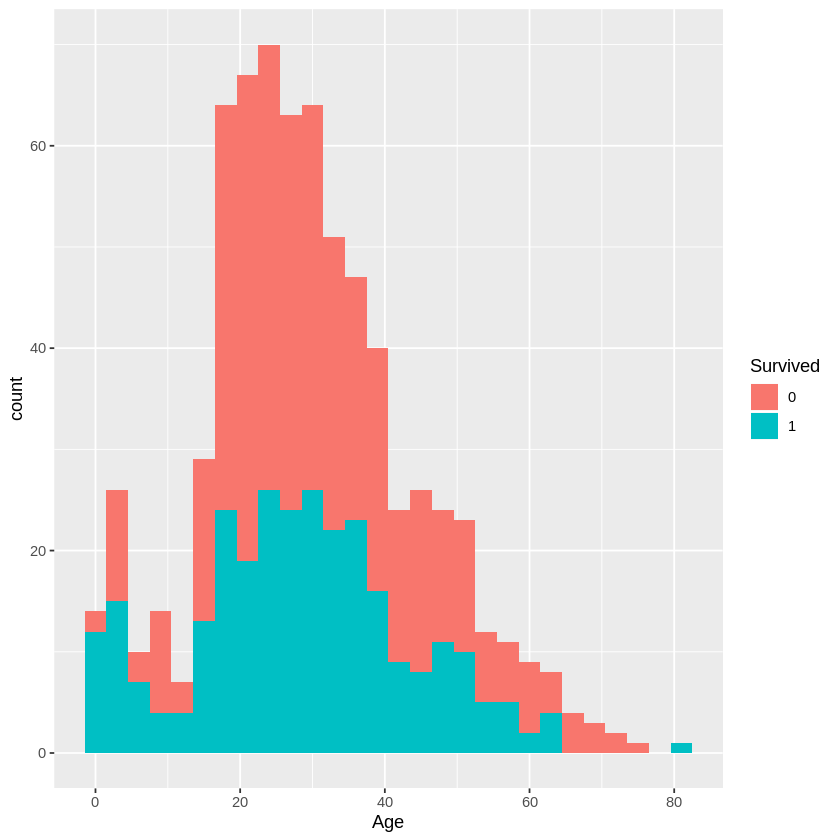

In [153]:
# That shows that families with a family size bigger or equal to 
#2 but less than 6 have a more than 50% to survive, in contrast 
#to families with 1 member or more than 5 members. 

# Survival as a function of age:
ggplot(data = full1[!(is.na(full[1:LT,]$Age)),],aes(x=Age,fill=Survived))+geom_histogram(binwidth =3)

Warning message:
“Removed 2 rows containing missing values (geom_bar).”

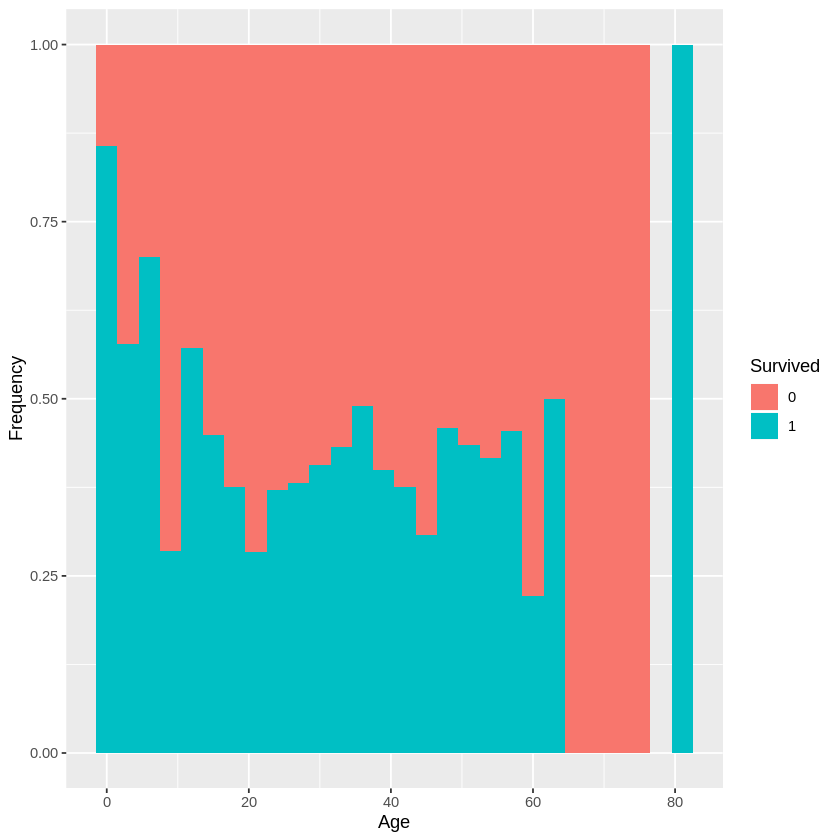

In [154]:
ggplot(data = full1[!is.na(full[1:LT,]$Age),],aes(x=Age,fill=Survived))+geom_histogram(binwidth = 3,position="fill")+ylab("Frequency")

Warning message:
“Removed 28 rows containing missing values (geom_bar).”

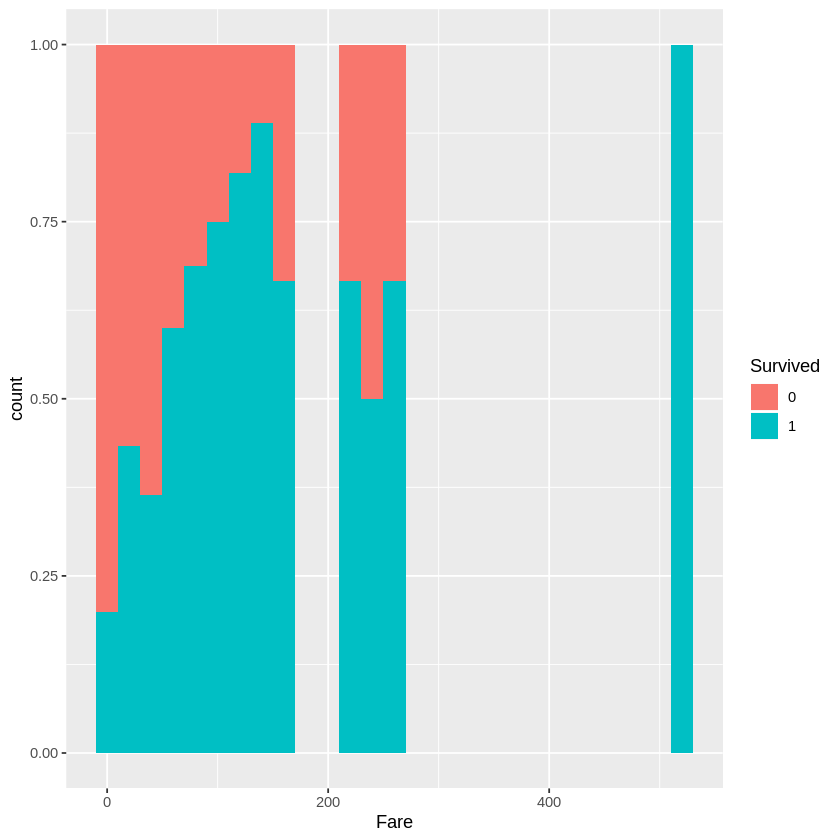

In [155]:
# Children (younger than 15YO) and old people (80 and up) had a better chance to survive.

# Is there a correlation between Fare and Survivial?
ggplot(data = full[1:LT,],aes(x=Fare,fill=Survived))+geom_histogram(binwidth =20, position="fill")

In [156]:
#missing values replaces with the mean of fare price
full$Fare[is.na(full$Fare)] = mean(full$Fare,na.rm=T)
# It seems like if your fare is bigger, than you have a better chance to survive.
sum(is.na(full$Age))

[1] 263

In [157]:
# There are a lot of missing values in the Age feature, so I'll put the mean instead of the missing values.
full$Age[is.na(full$Age)] <- mean(full$Age,na.rm=T)
sum(is.na(full$Age))

[1] 0

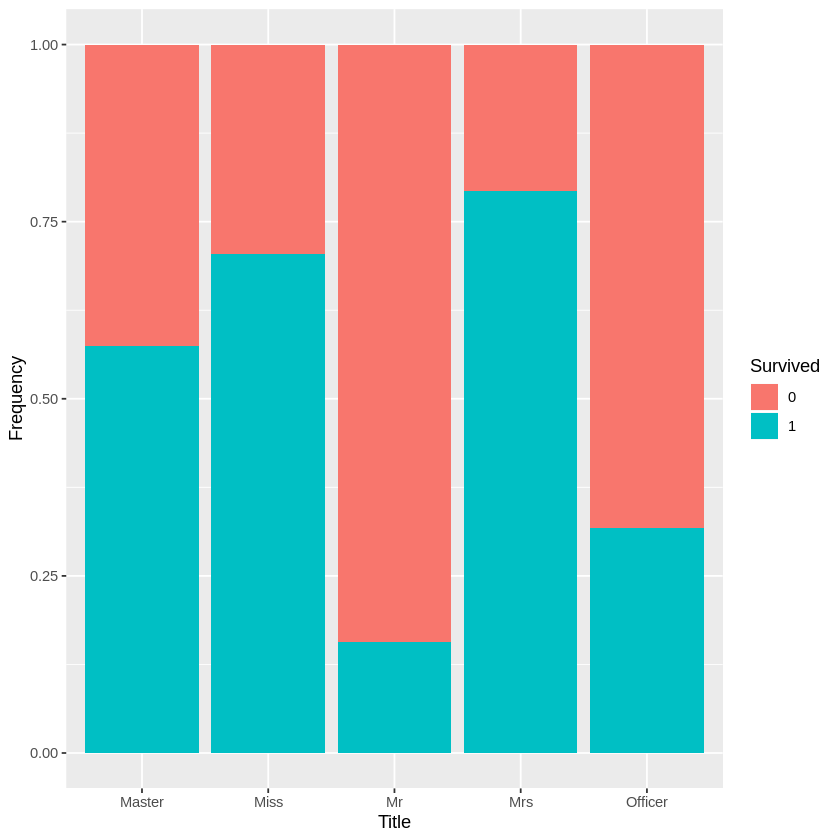

In [158]:
# The title of the passanger can affect his survive:
full$Title <- gsub('(.*, )|(\\..*)', '', full$Name)
full$Title[full$Title == 'Mlle']<- 'Miss' 
full$Title[full$Title == 'Ms']<- 'Miss'
full$Title[full$Title == 'Mme']<- 'Mrs' 
full$Title[full$Title == 'Lady']<- 'Miss'
full$Title[full$Title == 'Dona']<- 'Miss'
officer<- c('Capt','Col','Don','Dr','Jonkheer','Major','Rev','Sir','the Countess')
full$Title[full$Title %in% officer]<-'Officer'

full$Title<- as.factor(full$Title)

ggplot(data = full[1:LT,],aes(x=Title,fill=Survived))+geom_bar(position="fill")+ylab("Frequency")

# Prediction
At this time point we want to predict the chance of survival as a function of the other features. I’m going to keep just the correlated features: Pclass, Sex, Age, SibSp, Parch, Title and Fare. I’m going to divide the train set into two sets: training set (train1) and test set (train2) to be able to estimate the error of the prediction.

In [159]:
full

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Title
1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,,S,2,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.00000,1,0,PC 17599,71.2833,C85,C,2,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,,S,1,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,C123,S,2,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,,S,1,Mr
6,0,3,"Moran, Mr. James",male,29.88114,0,0,330877,8.4583,,Q,1,Mr
7,0,1,"McCarthy, Mr. Timothy J",male,54.00000,0,0,17463,51.8625,E46,S,1,Mr
8,0,3,"Palsson, Master. Gosta Leonard",male,2.00000,3,1,349909,21.0750,,S,5,Master
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00000,0,2,347742,11.1333,,S,3,Mrs
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00000,1,0,237736,30.0708,,C,2,Mrs


In [160]:
train_im= full[1:LT,c("Survived","Embarked","Pclass","Sex","Age","Fare","SibSp","Parch","Title")]
ind=sample(1:dim(train_im)[1],500) # Sample of 500 out of 891
train1=train_im[ind,] # The train set of the model
train2=train_im[-ind,] # The test set of the model

In [161]:
# Let's try to run a logistic regression
model <- glm(Survived ~.,family=binomial(link='logit'),data=train1)
summary(model)


Call:
glm(formula = Survived ~ ., family = binomial(link = "logit"), 
    data = train1)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2745  -0.6154  -0.3247   0.4657   2.8112  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   19.042142 882.744033   0.022 0.982790    
EmbarkedQ     -0.315059   0.545748  -0.577 0.563739    
EmbarkedS     -0.389503   0.360556  -1.080 0.280016    
Pclass2       -0.794532   0.432815  -1.836 0.066398 .  
Pclass3       -2.277909   0.436172  -5.223 1.77e-07 ***
Sexmale      -14.223929 882.743674  -0.016 0.987144    
Age           -0.024064   0.012451  -1.933 0.053272 .  
Fare           0.003499   0.003274   1.069 0.285158    
SibSp         -0.572526   0.178847  -3.201 0.001369 ** 
Parch         -0.432814   0.199104  -2.174 0.029720 *  
TitleMiss    -15.431004 882.743908  -0.017 0.986053    
TitleMr       -4.374642   0.767963  -5.696 1.22e-08 ***
TitleMrs     -14.938871 882.744004  -0.017 0.986498  

In [162]:
blub = anova(model, test="Chisq")
blub

,Df,Deviance,Resid. Df,Resid. Dev,Pr(>Chi)
NULL,NA,NA,499,652.2588,NA
Embarked,2,1.640704e+01,497,635.8517,2.736882e-04
Pclass,2,6.299774e+01,495,572.8540,2.090331e-14
Sex,1,1.216985e+02,494,451.1555,2.687269e-28
Age,1,1.490376e+01,493,436.2518,1.131370e-04
Fare,1,1.107255e-03,492,436.2507,9.734549e-01
SibSp,1,3.780333e+00,491,432.4703,5.185833e-02
Parch,1,4.371401e-01,490,432.0332,5.085060e-01
Title,4,4.510866e+01,486,386.9245,3.774423e-09


The difference between the null deviance and the residual deviance shows how our model is doing against the null model (a model with only the intercept). The wider this gap, the better. Analyzing the table we can see the drop in deviance when adding each variable one at a time. Again, adding Pclass, Sex and Age significantly reduces the residual deviance. The other variables seem to improve the model less even though SibSp has a low p-value. A large p-value here indicates that the model without the variable explains more or less the same amount of variation. Ultimately what you would like to see is a significant drop in deviance and the AIC.

In [170]:
blub$Deviance

[1]           NA 1.640704e+01 6.299774e+01 1.216985e+02 1.490376e+01
[6] 1.107255e-03 3.780333e+00 4.371401e-01 4.510866e+01

# embarked, pclass, SEX, title (age and SibSp not so much)
The difference between the null deviance and the residual deviance shows how our model is doing against the null model (a model with only the intercept). The wider this gap, the better. Analyzing the table we can see the drop in deviance when adding each variable one at a time. Again, adding Pclass and Sex significantly reduces the residual deviance. The other variables seem to improve the model less even though SibSp has a low p-value. A large p-value here indicates that the model without the variable explains more or less the same amount of variation. Ultimately what you would like to see is a significant drop in deviance and the AIC.


In [185]:
model2 = glm(Survived ~ Embarked+Pclass+Sex+Age+SibSp+Title,family=binomial(link='logit'),data=train1)
model3 = glm(Survived ~ Embarked+Pclass+Sex+Title,family=binomial(link='logit'),data=train1)
model4 = glm(Survived ~ Pclass+Sex+Title,family=binomial(link='logit'),data=train1)
model5 = glm(Survived ~ Pclass+Sex*Age+Title,family=binomial(link='logit'),data=train1)

In [176]:
cor(train1$Title, train1$Sex)

ERROR: Error in cor(train1$Title, train1$Sex): 'x' must be numeric


In [164]:
#model1
pred.train <- predict(model,train2)
pred.train <- ifelse(pred.train > 0.5,1,0)
mean(pred.train==train2$Survived)
t1<-table(pred.train,train2$Survived)
# Presicion and recall of the model
presicion<- t1[1,1]/(sum(t1[1,]))
recall<- t1[1,1]/(sum(t1[,1]))
presicion
recall
# F1 score
F1<- 2*presicion*recall/(presicion+recall)
F1

[1] 0.7902813

[1] 0.7449664

[1] 0.9736842

[1] 0.8441065

In [165]:
#model2
pred.train <- predict(model2,train2)
pred.train <- ifelse(pred.train > 0.5,1,0)
mean(pred.train==train2$Survived)
t1<-table(pred.train,train2$Survived)
# Presicion and recall of the model
presicion<- t1[1,1]/(sum(t1[1,]))
recall<- t1[1,1]/(sum(t1[,1]))
presicion
recall
# F1 score
F1<- 2*presicion*recall/(presicion+recall)
F1

[1] 0.7928389

[1] 0.7458194

[1] 0.9780702

[1] 0.8462998

In [166]:
#model3
pred.train <- predict(model3,train2)
pred.train <- ifelse(pred.train > 0.5,1,0)
mean(pred.train==train2$Survived)
t1<-table(pred.train,train2$Survived)
# Presicion and recall of the model
presicion<- t1[1,1]/(sum(t1[1,]))
recall<- t1[1,1]/(sum(t1[,1]))
presicion
recall
# F1 score
F1<- 2*presicion*recall/(presicion+recall)
F1



[1] 0.7723785

[1] 0.7234727

[1] 0.9868421

[1] 0.8348794

In [174]:

#model4
pred.train <- predict(model4,train2)
pred.train <- ifelse(pred.train > 0.5,1,0)
mean(pred.train==train2$Survived)
t1<-table(pred.train,train2$Survived)
# Presicion and recall of the model
presicion<- t1[1,1]/(sum(t1[1,]))
recall<- t1[1,1]/(sum(t1[,1]))
presicion
recall
# F1 score
F1<- 2*presicion*recall/(presicion+recall)
F1

[1] 0.769821

[1] 0.7211538

[1] 0.9868421

[1] 0.8333333

In [186]:
#model5
pred.train <- predict(model5,train2)
pred.train <- ifelse(pred.train > 0.5,1,0)
mean(pred.train==train2$Survived)
t1<-table(pred.train,train2$Survived)
# Presicion and recall of the model
presicion<- t1[1,1]/(sum(t1[1,]))
recall<- t1[1,1]/(sum(t1[,1]))
presicion
recall
# F1 score
F1<- 2*presicion*recall/(presicion+recall)
F1

[1] 0.769821

[1] 0.7211538

[1] 0.9868421

[1] 0.8333333

In [137]:
head(full)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [187]:
#lets run on the test set
test_set= full[892:1309,c('Embarked',"Pclass","Sex","Age","SibSp","Parch","Fare","Title")]
#test_set_better= full[892:1309,c('Embarked',"Pclass","Sex","Title")]


pred.test <- predict(model3,test_set)[1:418]
pred.test <- ifelse(pred.test > 0.5,1,0)

#pred_better.test = predict(model3,test_set_better)[1:418]
#pred_better.test <- ifelse(pred_better.test > 0.5,1,0)


In [189]:

res = data.frame(test$PassengerId,pred.test)
names(res)<-c("PassengerId","Survived")
write.csv(res,file="res.csv",row.names = F)



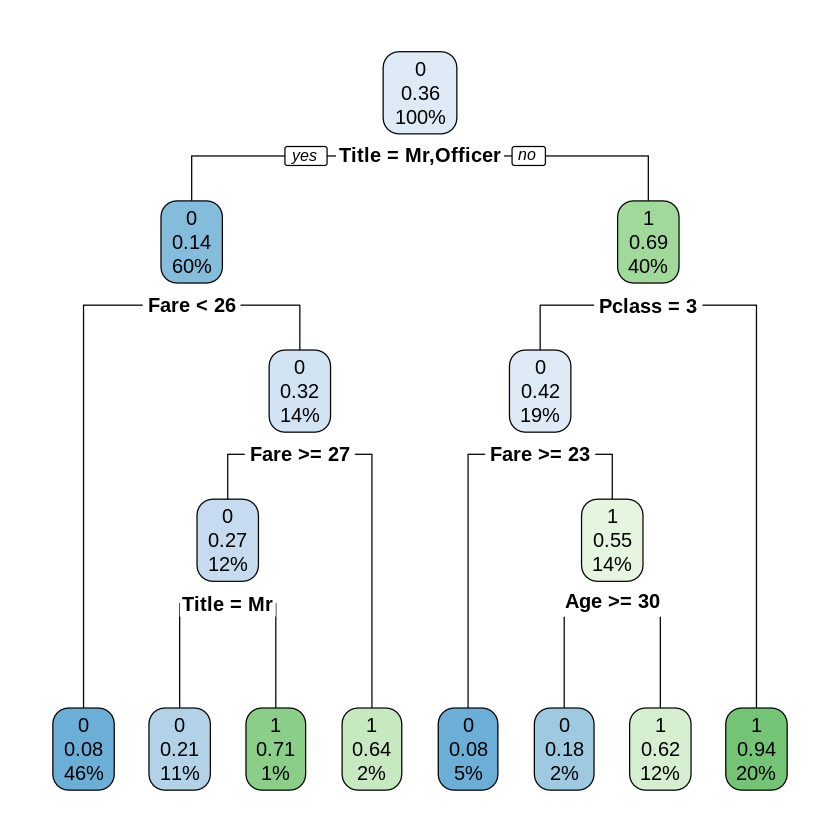

In [190]:
model_dt<- rpart(Survived ~.,data=train1, method="class")
rpart.plot(model_dt)

In [196]:
pred.train.dt <- predict(model_dt,train2,type = "class")
mean(pred.train.dt==train2$Survived)
t2<-table(pred.train.dt,train2$Survived)

presicion_dt<- t2[1,1]/(sum(t2[1,]))
recall_dt<- t2[1,1]/(sum(t2[,1]))
presicion_dt
recall_dt
F1_dt<- 2*presicion_dt*recall_dt/(presicion_dt+recall_dt)
F1_dt

[1] 0.8132992

[1] 0.8063241

[1] 0.8947368

[1] 0.8482328

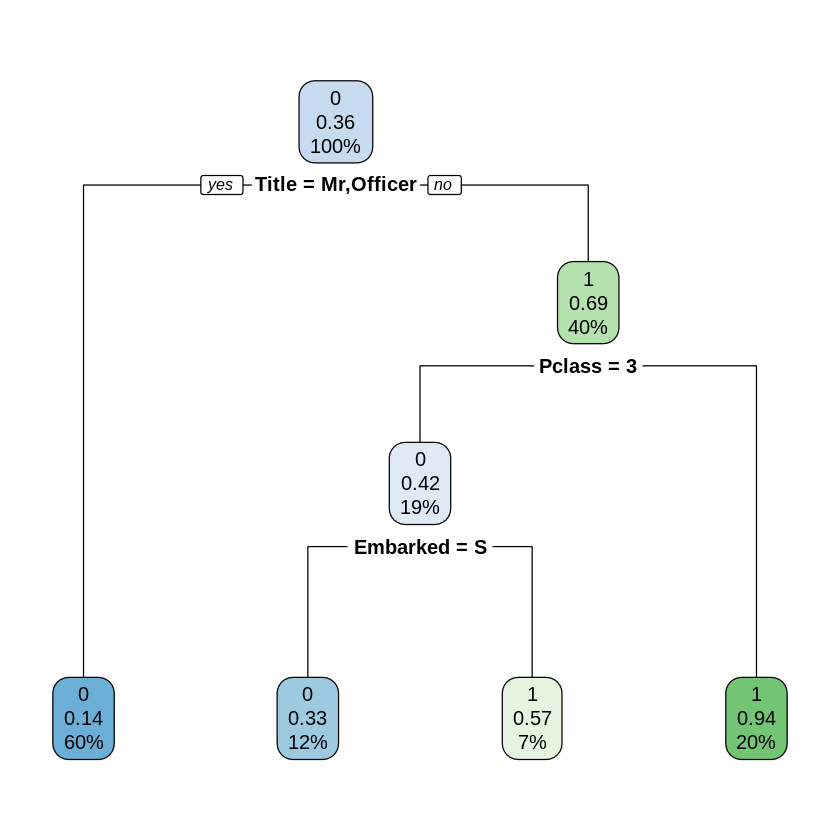

In [192]:
model_dt_2<- rpart(Survived ~Embarked+Pclass+Sex+Title,data=train1, method="class")
rpart.plot(model_dt_2)




In [193]:
pred.train.dt <- predict(model_dt_2,train2,type = "class")
mean(pred.train.dt==train2$Survived)

[1] 0.8107417

In [197]:
t2<-table(pred.train.dt,train2$Survived)

presicion_dt<- t2[1,1]/(sum(t2[1,]))
recall_dt<- t2[1,1]/(sum(t2[,1]))
presicion_dt
recall_dt
F1_dt<- 2*presicion_dt*recall_dt/(presicion_dt+recall_dt)
F1_dt

[1] 0.8063241

[1] 0.8947368

[1] 0.8482328

In [200]:
test_im[1:418,]

,Embarked,Pclass,Sex,Age,SibSp,Parch,Fare,Title
892,Q,3,male,34.50000,0,0,7.8292,Mr
893,S,3,female,47.00000,1,0,7.0000,Mrs
894,Q,2,male,62.00000,0,0,9.6875,Mr
895,S,3,male,27.00000,0,0,8.6625,Mr
896,S,3,female,22.00000,1,1,12.2875,Mrs
897,S,3,male,14.00000,0,0,9.2250,Mr
898,Q,3,female,30.00000,0,0,7.6292,Miss
899,S,2,male,26.00000,1,1,29.0000,Mr
900,C,3,female,18.00000,0,0,7.2292,Mrs
901,S,3,male,21.00000,2,0,24.1500,Mr


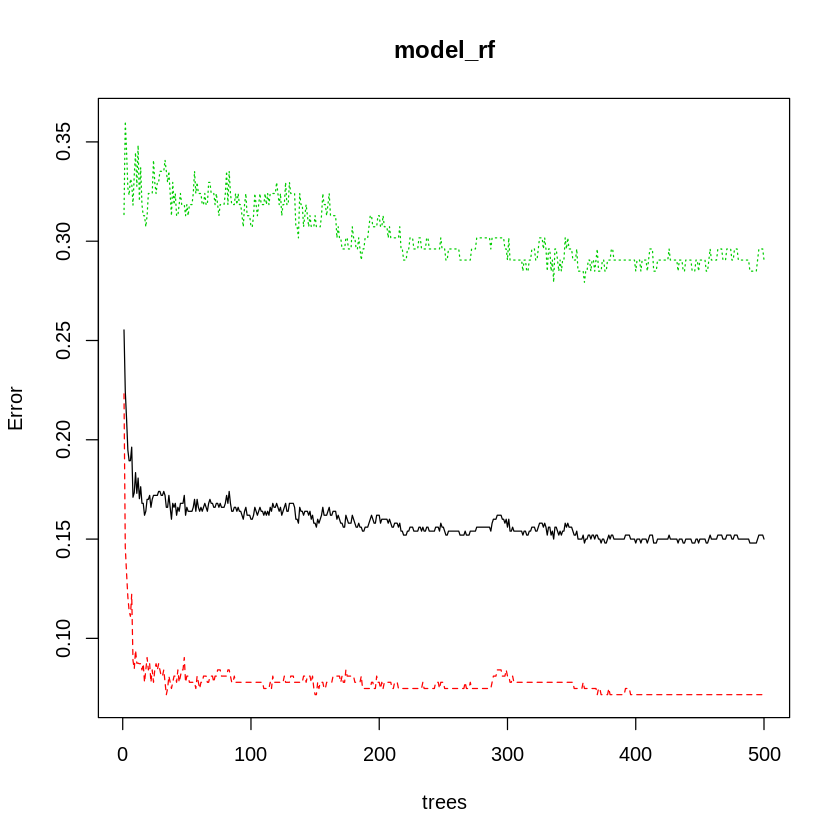

In [198]:
pred.test.dt <- predict(model_dt,test_im,type="class")[1:418]
res_dt<- data.frame(test$PassengerId,pred.test.dt)
names(res_dt)<-c("PassengerId","Survived")
write.csv(res_dt,file="res_dt.csv",row.names = F)

# Let's try to predict survival using a random forest.
model_rf<-randomForest(Survived~.,data=train1)
# Let's look at the error
plot(model_rf)

In [201]:
pred.train.rf <- predict(model_rf,train2)
mean(pred.train.rf==train2$Survived)

[1] 0.8081841

In [202]:
t1<-table(pred.train.rf,train2$Survived)
presicion<- t1[1,1]/(sum(t1[1,]))
recall<- t1[1,1]/(sum(t1[,1]))
presicion

[1] 0.7761733

In [203]:
F1<- 2*presicion*recall/(presicion+recall)
F1

[1] 0.8514851

In [205]:
# Let's run this model on the test set:
pred.test.rf <- predict(model_rf,test_set)[1:418]
res_rf<- data.frame(test$PassengerId,pred.test.rf)
names(res_rf)<-c("PassengerId","Survived")
write.csv(res_rf,file="res_rf.csv",row.names = F)